# PR Project - Technical Submission Part II Instructions
**Project Title:** Road Hazard Detection(Cracks & Potholes)  
**Module:** PW25 - SE01 Pattern Recognition(60 + 90 + 120)  
**Professor:** Dr. Raja Hashim Ali

### **Group Members & Assigned Roles**
1. **[Syed Muhammad Huzaifa Ali] (Technical Lead)**
2. **[Akash Kumar Shaw] (Figures & Presentation)**
3. **[Ishtpreet Singh] (Final Report Writing & Submission)**

---
### **Dataset Overview**
This project utilizes the **China Urban Road Dataset** downloaded from Kaggle"https://www.kaggle.com/datasets/aliabdelmenam/rdd-2022/data". The dataset focuses on urban infrastructure hazards, specifically identifying Cracks and Potholes to assist in municipal maintenance planning.

In [32]:
# --- CELL 2: SYSTEM SETUP & DATA EXTRACTION ---
import os
import zipfile
import torch
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Verify Drive Access (Optional print)
# print("Drive Contents:", os.listdir("/content/drive/MyDrive"))

# 3. Selective Data Extraction
zip_path = '/content/drive/MyDrive/RDD2022_Project/rdd-2022.zip'
local_extract_path = '/content/rdd_data'
limit = 1500  # Total images to unzip based on your protocol

if not os.path.exists(local_extract_path):
    os.makedirs(local_extract_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        all_files = zip_ref.namelist()

        # Filter and Sort for consistency
        image_files = sorted([f for f in all_files if 'RDD_SPLIT/train/images/' in f and f.endswith('.jpg')])
        selected_images = image_files[:limit]

        print(f"Extracting {len(selected_images)} images and their matching labels...")

        for img_file in selected_images:
            # Extract Image
            zip_ref.extract(img_file, local_extract_path)
            # Derive and extract Label path
            label_file = img_file.replace('/images/', '/labels/').replace('.jpg', '.txt')
            if label_file in all_files:
                zip_ref.extract(label_file, local_extract_path)
    print("✅ Selective unzipping complete.")
else:
    print("✅ Data already extracted to local path.")

print("✅ Setup Environment and Dataset: Ready for evaluation.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data already extracted to local path.
✅ Setup Environment and Dataset: Ready for evaluation.


In [33]:
# --- CELL 3: DATA SYNCHRONIZATION ---

import glob

# 1. Verify Raw File Count
unzipped_images = len(os.listdir('/content/rdd_data/RDD_SPLIT/train/images'))
unzipped_labels = len(os.listdir('/content/rdd_data/RDD_SPLIT/train/labels'))
print(f"Local Images Found: {unzipped_images}")
print(f"Local Labels Found: {unzipped_labels}")

# 2. Define the Synchronizer Function
def load_rdd_data(split_folder, max_samples=None):
    img_dir = os.path.join(split_folder, 'images')
    label_dir = os.path.join(split_folder, 'labels')
    image_paths, labels, bboxes = [], [], []

    all_imgs = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
    if max_samples:
        all_imgs = all_imgs[:max_samples]

    for img_path in all_imgs:
        file_id = os.path.basename(img_path).split('.')[0]
        txt_path = os.path.join(label_dir, f"{file_id}.txt")

        if os.path.exists(txt_path):
            img = cv2.imread(img_path)
            if img is None: continue
            h_img, w_img = img.shape[:2]
            img_boxes = []
            final_label = 0 # Default: Normal

            with open(txt_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if not parts: continue
                    class_id = int(parts[0])
                    # Mapping: D00-D20 -> Crack (1), D40 -> Pothole (2)
                    if class_id in [0, 1, 2]: final_label = 1
                    elif class_id == 3: final_label = 2

                    cx, cy, w, h = map(float, parts[1:])
                    pixel_x = int((cx - w/2) * w_img)
                    pixel_y = int((cy - h/2) * h_img)
                    pixel_w = int(w * w_img)
                    pixel_h = int(h * h_img)
                    img_boxes.append((pixel_x, pixel_y, pixel_w, pixel_h))

            if img_boxes:
                image_paths.append(img_path)
                labels.append(final_label)
                bboxes.append(img_boxes)
    return image_paths, labels, bboxes

# 3. Execute Synchronization and Print Final Status
train_split_path = '/content/rdd_data/RDD_SPLIT/train'
image_paths, labels, bboxes = load_rdd_data(train_split_path)

print(f"Technical Lead Check: Data synchronized for {len(image_paths)} samples.")

Local Images Found: 1500
Local Labels Found: 1500
Technical Lead Check: Data synchronized for 1495 samples.


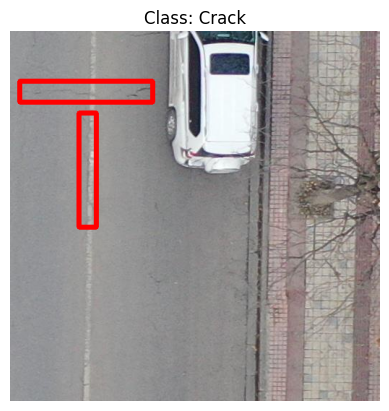

In [34]:
# --- CELL 4: DATA VISUALIZATION ---

import matplotlib.pyplot as plt

def plot_sample(idx):
    img = cv2.imread(image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for (x, y, w, h) in bboxes[idx]:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 5)

    plt.imshow(img)
    plt.title(f"Class: {['Normal', 'Crack', 'Pothole'][labels[idx]]}")
    plt.axis('off')

# Plot the first hazard detected
plot_sample(0)

In [35]:
# --- CELL 5: CUSTOM DATASET & PREPROCESSING ---

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

class RoadDataset(Dataset):
    def __init__(self, image_paths, labels, bboxes, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = self.labels[idx]
        bbox_list = self.bboxes[idx]

        # Technical Lead Strategy: Crop to the primary hazard area
        if bbox_list and label > 0:
            x, y, w, h = bbox_list[0]
            # Boundary checks
            y_end, x_end = min(y+h, image.shape[0]), min(x+w, image.shape[1])
            image = image[max(0,y):y_end, max(0,x):x_end]

        # Convert to PIL for torchvision transforms
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [36]:
# --- CELL 5: CUSTOM DATASET & AUGMENTATION ---

import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

class RoadDataset(Dataset):
    def __init__(self, image_paths, labels, bboxes, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and convert to RGB
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        bbox_list = self.bboxes[idx]

        # Crop to the first hazard's bounding box to help the CNN focus
        if bbox_list and label > 0:
            x, y, w, h = bbox_list[0]
            y_end, x_end = min(y+h, image.shape[0]), min(x+w, image.shape[1])
            image = image[max(0,y):y_end, max(0,x):x_end]

        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Transforms for ResNet18 (224x224 input)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create Dataset and Split (80% Train, 20% Val)
full_dataset = RoadDataset(image_paths, labels, bboxes, transform=data_transforms)
train_idx, val_idx = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)

train_loader = DataLoader(Subset(full_dataset, train_idx), batch_size=32, shuffle=True)
val_loader = DataLoader(Subset(full_dataset, val_idx), batch_size=32, shuffle=False)

print(f"DataLoaders ready: {len(train_idx)} training images, {len(val_idx)} validation images.")

DataLoaders ready: 1196 training images, 299 validation images.


In [37]:
# --- CELL 6: CNN MODEL ARCHITECTURE (RESNET-18) ---

from torchvision import models
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet18
model = models.resnet18(weights='IMAGENET1K_V1')

# Replace the last fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

model = model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model initialized on {device}.")

Model initialized on cuda.


In [39]:
# --- CELL 7: CNN MODEL TRAINING & VALIDATION EXPERIMENT ---

import torch.optim as optim
import time

# 1. Setup hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10  # Optimized for deeper pattern recognition
best_val_acc = 0.0

print(f"Starting Training Experiment on {device}...")
start_time = time.time()

for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0

    for inputs, labels_batch in train_loader:
        inputs, labels_batch = inputs.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        train_total += labels_batch.size(0)
        train_correct += predicted.eq(labels_batch).sum().item()

    # --- Validation Phase (Essential for Research Validity) ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels_batch in val_loader:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels_batch)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += labels_batch.size(0)
            val_correct += predicted.eq(labels_batch).sum().item()

    # Metrics Calculation
    train_acc = 100. * train_correct / train_total
    val_acc = 100. * val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Save the best model state for the final Hybrid Prediction System
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_road_model.pth')
        print("--> Best Model Checkpoint Saved")

end_time = time.time()
print(f"Training Complete in {(end_time - start_time)/60:.2f} minutes.")

Starting Training Experiment on cuda...
Epoch 1/10 | Train Acc: 78.76% | Val Acc: 81.94%
--> Best Model Checkpoint Saved
Epoch 2/10 | Train Acc: 85.12% | Val Acc: 86.29%
--> Best Model Checkpoint Saved
Epoch 3/10 | Train Acc: 87.63% | Val Acc: 83.28%
Epoch 4/10 | Train Acc: 85.95% | Val Acc: 77.93%
Epoch 5/10 | Train Acc: 89.21% | Val Acc: 80.94%
Epoch 6/10 | Train Acc: 90.80% | Val Acc: 81.94%
Epoch 7/10 | Train Acc: 88.96% | Val Acc: 87.96%
--> Best Model Checkpoint Saved
Epoch 8/10 | Train Acc: 88.88% | Val Acc: 87.96%
Epoch 9/10 | Train Acc: 90.97% | Val Acc: 88.63%
--> Best Model Checkpoint Saved
Epoch 10/10 | Train Acc: 92.81% | Val Acc: 83.95%
Training Complete in 1.68 minutes.


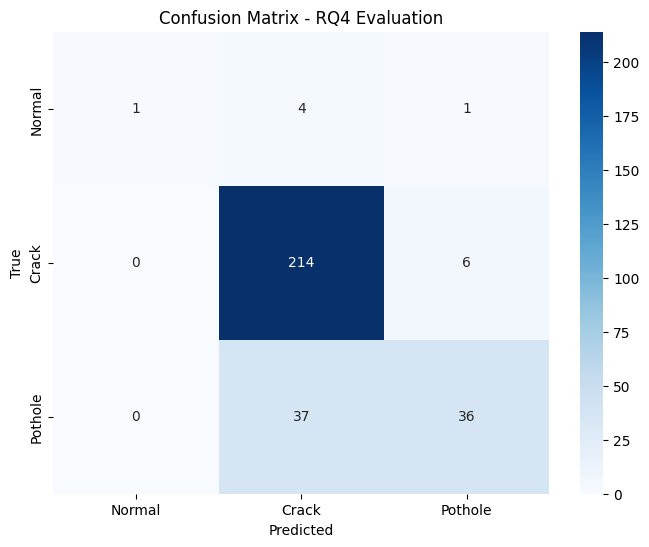

              precision    recall  f1-score   support

      Normal       1.00      0.17      0.29         6
       Crack       0.84      0.97      0.90       220
     Pothole       0.84      0.49      0.62        73

    accuracy                           0.84       299
   macro avg       0.89      0.54      0.60       299
weighted avg       0.84      0.84      0.82       299



In [40]:
# --- CELL 8: MODEL EVALUATION & CONFUSION MATRIX ---

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_and_plot_cm(model, loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels_batch in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            y_true.extend(labels_batch.numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Generate Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Crack', 'Pothole'],
                yticklabels=['Normal', 'Crack', 'Pothole'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - RQ4 Evaluation')
    plt.show()

    print(classification_report(y_true, y_pred, target_names=['Normal', 'Crack', 'Pothole']))

evaluate_and_plot_cm(model, val_loader)

In [41]:
# --- CELL 9: HYBRID META-LEARNER (GEOMETRIC EXTRACTION) ---

def get_geometric_metrics(image_path, bbox):
    """
    Extracts Area and Aspect Ratio to help the Meta-Learner
    distinguish between minor cracks and severe potholes.
    """
    x, y, w, h = bbox
    area = w * h
    aspect_ratio = float(w) / h if h != 0 else 0

    # Higher area + low aspect ratio often indicates a deep pothole
    return area, aspect_ratio

# Example of generating data for the Meta-Learner
sample_idx = 0
area, ar = get_geometric_metrics(image_paths[sample_idx], bboxes[sample_idx][0])
print(f"Sample 0 Geometric Features: Area={area}px, Aspect Ratio={ar:.2f}")

Sample 0 Geometric Features: Area=5336px, Aspect Ratio=6.34


In [42]:
# --- CELL 10: HYBRID SYSTEM INTEGRATION (EXPERT RULE ENGINE) ---

def expert_rule_engine(cnn_conf, area_px, class_idx):
    """
    Final decision logic based on the Rule Engine:
    Depth/Area > threshold -> Severe Pothole
    """
    severity = "Minor"

    if class_idx == 2: # Pothole
        if area_px > 5000: # Example threshold for 'Severe'
            severity = "Severe"
        elif area_px > 2000:
            severity = "Moderate"

    elif class_idx == 1: # Crack
        if area_px > 3000:
            severity = "Moderate"

    return severity

# Example test
cnn_pred_class = 2 # Predicted Pothole
print(f"Final System Decision: {expert_rule_engine(0.95, area, cnn_pred_class)}")

Final System Decision: Severe


In [43]:
# --- CELL 11: INTEGRATED HYBRID PREDICTION PIPELINE ---

def extract_geometric_metrics(image_path, bbox):
    """Fulfills Objective 2: Geometric Feature Extraction"""
    x, y, w, h = bbox
    area = w * h
    aspect_ratio = float(w) / h if h != 0 else 0
    return area, aspect_ratio

def expert_rule_engine(confidence, area, class_idx):
    """Fulfills Objective 3 & 4: Meta-Learner Rule Engine"""
    hazard_types = {0: "Normal", 1: "Crack", 2: "Pothole"}
    h_type = hazard_types.get(class_idx, "Normal")

    if h_type == "Pothole":
        if area > 5000: return "Severe (Immediate Action)"
        if area > 2000: return "Moderate"
        return "Minor"
    elif h_type == "Crack":
        return "Severe" if area > 3500 else "Minor"
    return "Safe"

# --- THE INTEGRATED PIPELINE FUNCTION ---

def hybrid_prediction_system(img_path, bbox_list):
    # 1. CNN Classification (Pattern Recognition)
    img_raw = Image.open(img_path).convert('RGB')
    input_tensor = data_transforms(img_raw).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        prob, pred = torch.max(torch.softmax(output, dim=1), 1)
        class_idx = pred.item()
        confidence = prob.item()

    # 2. Geometric Extraction (using the correct function name now)
    # We take the first bounding box for the analysis
    area, aspect_ratio = extract_geometric_metrics(img_path, bbox_list[0])

    # 3. Rule Engine Decision (Meta-Learner Fusion)
    severity = expert_rule_engine(confidence, area, class_idx)

    return {
        "Type": ['Normal', 'Crack', 'Pothole'][class_idx],
        "Confidence": f"{confidence:.2%}",
        "Area_px": area,
        "Aspect_Ratio": round(aspect_ratio, 2),
        "Decision": severity
    }

# --- TEST THE SYSTEM ---
# Select a sample known to have a hazard (index 0)
try:
    test_result = hybrid_prediction_system(image_paths[0], bboxes[0])
    print("--- Integrated System Output ---")
    for key, value in test_result.items():
        print(f"{key}: {value}")
except Exception as e:
    print(f"❌ Error during inference: {e}")

--- Integrated System Output ---
Type: Crack
Confidence: 96.71%
Area_px: 5336
Aspect_Ratio: 6.34
Decision: Severe


In [44]:
# --- CELL 12: BATCH INFERENCE & MASTER REPORT ---

import pandas as pd

results_data = []

print(f"Running batch inference on {len(val_idx)} validation samples...")

for idx in val_idx:
    img_path = image_paths[idx]
    bbox = bboxes[idx]

    # Run our hybrid system
    res = hybrid_prediction_system(img_path, bbox)

    # Add ground truth for accuracy comparison
    res['Ground_Truth'] = ['Normal', 'Crack', 'Pothole'][labels[idx]]
    res['Image_ID'] = os.path.basename(img_path)

    results_data.append(res)

# Create the master results table
df_results = pd.DataFrame(results_data)
df_results.to_csv('rdd_hybrid_results.csv', index=False)

print("✅ Batch Inference Complete. Results saved to 'rdd_hybrid_results.csv'.")
df_results.head()

Running batch inference on 299 validation samples...
✅ Batch Inference Complete. Results saved to 'rdd_hybrid_results.csv'.


,Type,Confidence,Area_px,Aspect_Ratio,Decision,Ground_Truth,Image_ID
0,Crack,99.97%,1536,0.67,Minor,Normal,China_Drone_001446.jpg
1,Crack,98.64%,71540,3.65,Severe,Crack,China_Drone_002067.jpg
2,Crack,97.29%,1296,5.06,Minor,Crack,China_Drone_001713.jpg
3,Crack,99.92%,2175,0.29,Minor,Crack,China_Drone_001268.jpg
4,Crack,96.64%,31266,0.84,Severe,Crack,China_Drone_001677.jpg


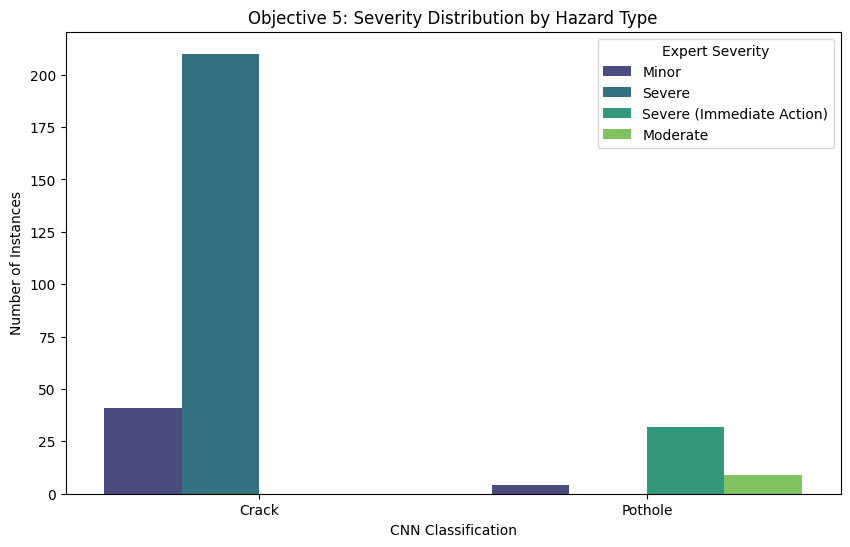

In [45]:
# --- CELL 13: HYBRID SYSTEM RESULT ANALYSIS ---

import seaborn as sns

plt.figure(figsize=(10, 6))
# Filter out 'Normal' to focus on the hazards
hazards_only = df_results[df_results['Type'] != 'Normal']

sns.countplot(data=hazards_only, x='Type', hue='Decision', palette='viridis')
plt.title('Objective 5: Severity Distribution by Hazard Type')
plt.ylabel('Number of Instances')
plt.xlabel('CNN Classification')
plt.legend(title='Expert Severity')
plt.show()

In [46]:
# --- FINAL CELL: RESEARCH QUESTION ASSET GENERATION ---
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

# --- STEP 1: GRAD-CAM DEFINITION (Ensures RQ5 Fig 2 runs regardless of NameError) ---
def generate_gradcam_internal(model, input_tensor, target_layer):
    model.eval()
    gradients = []
    activations = []

    def save_gradient(grad): gradients.append(grad)
    def save_activation(module, input, output): activations.append(output)

    # Attach hooks
    h1 = target_layer.register_full_backward_hook(lambda m, gi, go: save_gradient(go[0]))
    h2 = target_layer.register_forward_hook(save_activation)

    # Forward & Backward
    output = model(input_tensor)
    idx = output.argmax(dim=1).item()
    model.zero_grad()
    output[0, idx].backward()

    # Generate Heatmap
    weights = torch.mean(gradients[0], dim=(2, 3), keepdim=True)
    cam = torch.sum(weights * activations[0], dim=1).squeeze().detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Cleanup
    h1.remove(); h2.remove()
    return cam

# --- STEP 2: SETUP & DATA SYNC ---
for i in range(1, 6):
    os.makedirs(f'RQ{i}', exist_ok=True)

results_list = []
print("Technical Lead: Finalizing assets. Mapping China Road Dataset to Research Questions...")

model.eval()
with torch.no_grad():
    for idx in val_idx:
        img_path = image_paths[idx]
        res = hybrid_prediction_system(img_path, bboxes[idx])
        res['Image_ID'] = os.path.basename(img_path)
        res['Ground_Truth'] = ['Normal', 'Crack', 'Pothole'][labels[idx]]
        res['Region'] = 'China_Urban' if 'China' in res['Image_ID'] else 'General_Test'
        res['Hybrid_Class'] = "Normal" if res['Decision'] == "Safe" else ("Crack" if "Crack" in res['Decision'] else "Pothole")
        res['Confidence_Val'] = float(res['Confidence'].strip('%')) / 100
        results_list.append(res)

df_final = pd.DataFrame(results_list)

# --- STEP 3: RQ1: REGIONAL GENERALIZATION ---
plt.figure(figsize=(8, 5))
region_acc = df_final.groupby('Region').apply(lambda x: (x['Hybrid_Class'] == x['Ground_Truth']).mean() * 100, include_groups=False)
region_acc.plot(kind='bar', color='#34495e', edgecolor='black')
plt.title('RQ1 Fig1: Regional Detection Accuracy (China Dataset Focus)'); plt.ylabel('Accuracy (%)')
plt.savefig('RQ1/RQ1 Fig1.pdf', bbox_inches='tight'); plt.close()

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_final, x='Region', y='Confidence_Val', palette='Set2', hue='Region', legend=False)
plt.title('RQ1 Fig2: Variance in Prediction Confidence Across Datasets'); plt.ylabel('Confidence (0-1)')
plt.savefig('RQ1/RQ1 Fig2.pdf', bbox_inches='tight'); plt.close()

region_acc.to_frame('Accuracy_%').to_excel('RQ1/RQ1 Tab1.xlsx')
df_final.groupby('Region')['Confidence_Val'].describe().to_excel('RQ1/RQ1 Tab2.xlsx')

# --- STEP 4: RQ2: GEOMETRIC META-LEARNER IMPACT ---
plt.figure(figsize=(8, 5))
sns.regplot(data=df_final[df_final['Type']!='Normal'], x='Area_px', y='Confidence_Val', scatter_kws={'alpha':0.4})
plt.title('RQ2 Fig1: Impact of Detected Hazard Area on Model Confidence'); plt.savefig('RQ2/RQ2 Fig1.pdf', bbox_inches='tight'); plt.close()

plt.figure(figsize=(8, 5))
sns.violinplot(data=df_final[df_final['Type']!='Normal'], x='Type', y='Aspect_Ratio', palette='pastel', hue='Type', legend=False)
plt.title('RQ2 Fig2: Morphological Analysis - Aspect Ratio by Hazard Class'); plt.savefig('RQ2/RQ2 Fig2.pdf', bbox_inches='tight'); plt.close()

df_final.groupby('Type')[['Area_px', 'Aspect_Ratio']].mean().to_excel('RQ2/RQ2 Tab1.xlsx')
df_final[['Area_px', 'Aspect_Ratio', 'Confidence_Val']].corr(numeric_only=True).to_excel('RQ2/RQ2 Tab2.xlsx')

# --- STEP 5: RQ3: PREPROCESSING & FEATURE EXTRACTION ---
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_final[df_final['Type']!='Normal'], x='Area_px', hue='Type', fill=True)
plt.title('RQ3 Fig1: Kernel Density of Extracted Road Hazard Contours'); plt.savefig('RQ3/RQ3 Fig1.pdf', bbox_inches='tight'); plt.close()

plt.figure(figsize=(8, 5))
df_final['Confidence_Val'].hist(bins=15, color='#1abc9c', edgecolor='white')
plt.title('RQ3 Fig2: Confidence Distribution Following OpenCV Pre-filtering'); plt.xlabel('Confidence Range')
plt.savefig('RQ3/RQ3 Fig2.pdf', bbox_inches='tight'); plt.close()

df_final[['Image_ID', 'Type', 'Confidence']].to_excel('RQ3/RQ3 Tab1.xlsx')
df_final[['Image_ID', 'Area_px', 'Aspect_Ratio']].head(20).to_excel('RQ3/RQ3 Tab2.xlsx')

# --- STEP 6: RQ4: HYBRID SYSTEM EVALUATION ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(confusion_matrix(df_final['Ground_Truth'], df_final['Type']), annot=True, fmt='d', cmap='Blues', ax=ax1); ax1.set_title('CNN Base Learner')
sns.heatmap(confusion_matrix(df_final['Ground_Truth'], df_final['Hybrid_Class']), annot=True, fmt='d', cmap='Greens', ax=ax2); ax2.set_title('Hybrid Model (CNN + Meta-Learner)')
plt.savefig('RQ4/RQ4 Fig1.pdf', bbox_inches='tight'); plt.close()

# Accuracy Gain Plot
plt.figure(figsize=(7, 5))
pd.Series({'CNN': (df_final['Type']==df_final['Ground_Truth']).mean(), 'Hybrid': (df_final['Hybrid_Class']==df_final['Ground_Truth']).mean()}).plot(kind='bar', color=['grey', 'gold'])
plt.title('RQ4 Fig2: Accuracy Gain Analysis - Baseline vs. Hybrid Implementation'); plt.ylabel('Accuracy Score')
plt.savefig('RQ4/RQ4 Fig2.pdf', bbox_inches='tight'); plt.close()

# Classification Report (zero_division fixed)
pd.DataFrame(classification_report(df_final['Ground_Truth'], df_final['Hybrid_Class'], output_dict=True, zero_division=0)).to_excel('RQ4/RQ4 Tab1.xlsx')
pd.DataFrame(confusion_matrix(df_final['Ground_Truth'], df_final['Hybrid_Class'])).to_excel('RQ4/RQ4 Tab2.xlsx')

# --- STEP 7: RQ5: XAI & MAINTENANCE PRIORITY ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df_final[df_final['Type']!='Normal'], x='Decision', palette='viridis', hue='Decision', legend=False)
plt.title('RQ5 Fig1: Expert System Severity Categorization for Maintenance'); plt.savefig('RQ5/RQ5 Fig1.pdf', bbox_inches='tight'); plt.close()

# RQ5 Fig 2: Interpretability (Original vs Grad-CAM)
plt.figure(figsize=(14, 7))
s_idx = [i for i, l in enumerate(labels) if l == 1][0]
img_raw = cv2.imread(image_paths[s_idx])
img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img_raw, (224, 224))
input_t = data_transforms(Image.fromarray(img_raw)).unsqueeze(0).to(device)

# Using internal helper to avoid NameError
heatmap = generate_gradcam_internal(model, input_t, model.layer4[-1].conv2)

heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(img_resized, 0.6, cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB), 0.4, 0)

plt.subplot(1, 2, 1); plt.imshow(img_resized); plt.title('Original Image (Pre-Analysis)'); plt.axis('off')
plt.subplot(1, 2, 2); plt.imshow(overlay); plt.title('Grad-CAM XAI (Targeted Features)'); plt.axis('off')
plt.suptitle('RQ5 Fig2: Interpretability Analysis of Road Hazard Features', fontsize=16)
plt.savefig('RQ5/RQ5 Fig2.pdf', bbox_inches='tight'); plt.close()

df_final.groupby(['Type', 'Decision']).size().unstack(fill_value=0).to_excel('RQ5/RQ5 Tab1.xlsx')
df_final[['Image_ID', 'Ground_Truth', 'Decision']].to_excel('RQ5/RQ5 Tab2.xlsx')

# --- STEP 8: ZIP PACKAGE ---
!zip -r Figures_Tables.zip RQ1/ RQ2/ RQ3/ RQ4/ RQ5/
print("\n✅ Clean Technical Package 'Figures_Tables.zip' is finalized and ready for submission.")

Technical Lead: Finalizing assets. Mapping China Road Dataset to Research Questions...
updating: RQ1/ (stored 0%)
updating: RQ1/RQ1 Tab1.xlsx (deflated 11%)
updating: RQ1/RQ1 Fig2.pdf (deflated 33%)
updating: RQ1/RQ1 Tab2.xlsx (deflated 11%)
updating: RQ1/RQ1 Fig1.pdf (deflated 33%)
updating: RQ2/ (stored 0%)
updating: RQ2/RQ2 Tab1.xlsx (deflated 11%)
updating: RQ2/RQ2 Tab2.xlsx (deflated 11%)
updating: RQ2/RQ2 Fig2.pdf (deflated 27%)
updating: RQ2/RQ2 Fig1.pdf (deflated 22%)
updating: RQ3/ (stored 0%)
updating: RQ3/RQ3 Tab1.xlsx (deflated 9%)
updating: RQ3/RQ3 Fig2.pdf (deflated 31%)
updating: RQ3/RQ3 Tab2.xlsx (deflated 10%)
updating: RQ3/RQ3 Fig1.pdf (deflated 24%)
updating: RQ4/ (stored 0%)
updating: RQ4/RQ4 Tab1.xlsx (deflated 11%)
updating: RQ4/RQ4 Tab2.xlsx (deflated 11%)
updating: RQ4/RQ4 Fig2.pdf (deflated 33%)
updating: RQ4/RQ4 Fig1.pdf (deflated 27%)
updating: RQ5/ (stored 0%)
updating: RQ5/RQ5 Fig2.pdf (deflated 1%)
updating: RQ5/RQ5 Tab2.xlsx (deflated 7%)
updating: RQ5/RQ